# Evaluación y Uso de YOLO para Detección de Objetos

## Introducción

En este proyecto, exploramos y evaluamos el rendimiento del modelo **YOLO (You Only Look Once)** para la detección de objetos en imágenes. Dado que YOLO utiliza una arquitectura ViT para la detección en imágen devolviendo bounding boxes, es ideal para empezar viendo el funcionamiento de modelos en hugging face

El objetivo principal de este trabajo es comprobar la funcionalidad de YOLO y practicar su implementación en Jupiter Notebook para familiarizarnos con las herramientas

## Objetivos

- Implementar y probar el modelo **YOLO** en imágenes de prueba.
- Entrenar el modelo en un conjunto de datos propuesto y evaluar su rendimiento.
- Practicar con todo ello implementaciones y evaluacion de modelos en Hugging Face

¡Comencemos con la evaluación del modelo!

**Comprobar el modelo**

Para ello seguiremos los siguientes pasos

1. Elegimos un dataset apropiado
2. Procesamos los datos para cumplir con el formato de entrada del modelo
3. Entrenamos el modelo
4. Evaluamos el rendimiento

### 1 Elegir un dataste apropiado

En este caso usaremos COCO, es un dataset de imágenes muy utilizado y escojemos este ya que es el usado por los propios creadores del modelo para evaluar su rendimiento, por lo que trataremos de imitar su experimento

COCO tiene una estructura particular en la que la información de cada imagen viene en un JSON, los detalles del formato se pueden encontrar [aquí](https://cocodataset.org/#format-data). Pero esencialmente buscamos crear un diccionario con las imagenes, id, bbx y clase para poder cargarlo en el Dataloader

In [28]:
from utils import COCODataProcessor
COCO_DIR = 'datasets/COCO_2017'
NUM_EPOCH = 30              # 🔄 Numero de epocas del entrenamiento 
BATCH_SIZE = 10             # 👝 Numero de imágenes por batch
TRAIN_SIZE = 3000           # 🏃‍♂ Imágenes para entrenamiento
VAL_SIZE = 700              # 📈 Imágenes para validacion
TEST_SIZE = 500             # ✅ Imágenes para test
TRAIN_RES = (256, 256)      # 📷 Resolucion de la imagen en entrenamiento


coco_data = COCODataProcessor(f'{COCO_DIR}/annotations/instances_train2017.json', 
                              f'{COCO_DIR}/train2017', TRAIN_RES)

print(f"coco train annotations: {coco_data.json['annotations'][0]}")
print(f"coco train images: {coco_data.json['images'][0]}")

coco train annotations: {'segmentation': [[239.97, 260.24, 222.04, 270.49, 199.84, 253.41, 213.5, 227.79, 259.62, 200.46, 274.13, 202.17, 277.55, 210.71, 249.37, 253.41, 237.41, 264.51, 242.54, 261.95, 228.87, 271.34]], 'area': 2765.1486500000005, 'iscrowd': 0, 'image_id': 558840, 'bbox': [199.84, 200.46, 77.71, 70.88], 'category_id': 58, 'id': 156}
coco train images: {'license': 3, 'file_name': '000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}


Como podemos observar tenemos una cantiadad suficiente de datos por lo que ya que este ejercicio es para familiarizarnos con el proceso vamos a partir de este dataset coger unos splits de train test y validation mucho menores para ver el resultado

In [29]:
print(coco_data.get_shape())

(118287, 3)


Estos splits se hacen utilizando los ids de las imagenes que son las keys del diccionario, y una vez repartidas aleatoriamente estas keys, creamos unos nuevos diccionarios con las entradas de los diccionarios.

Shapes: Train: (3000, 4), Test: (500, 4), Validation: (700, 4)
from image 558840 class: 50
from image 200365 class: 47
from image 495357 class: 1
from image 116061 class: 6


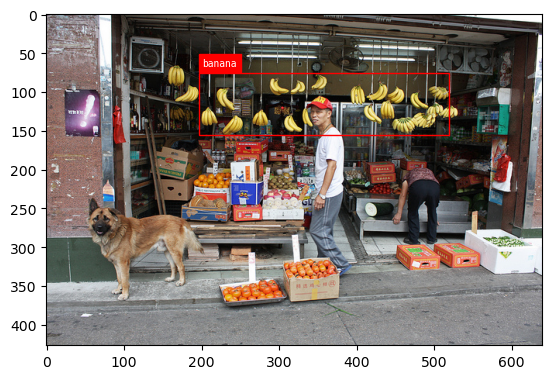

In [30]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random

# random_num = random.randint(1, 500)
random_num = 123

# Convertimos el dataset en un array de indices de imagenes para hacer el split mas eficientemente
image_ids = list(coco_data.image_dict.keys())

# Obtenemos la cantidad de imagenes con las que queremos trabajar aleatriamente
selected_ids = np.random.choice(image_ids, size=TRAIN_SIZE+VAL_SIZE+TEST_SIZE, replace=False)

# Separamos Test del conjunto de imagenes
train_val_ids, test_ids = train_test_split(selected_ids, test_size=TEST_SIZE, random_state=random_num)

# Separamos validation de train y terminamos con los 3 conjuntos
train_ids, val_ids = train_test_split(train_val_ids, test_size=VAL_SIZE, random_state=random_num)

# Obtenemos los dataset conteniendo cada uno las imagenes seleccionadas
dtrain = coco_data.dataset_from_dict_ids(train_ids)
dval = coco_data.dataset_from_dict_ids(val_ids)
dtest = coco_data.dataset_from_dict_ids(test_ids)

# finalmente vemos unos ejemplos del contenido del dataset
print(f"Shapes: Train: {dtrain.shape}, Test: {dtest.shape}, Validation: {dval.shape}")
for i, (img_id, data) in enumerate(coco_data.image_dict.items()):
    if i < 4: print(f"from image {img_id} class: {data['category_id']}")
    else: break

coco_data.show_image(train_ids[0])


#### Crear los DataLoaders

Una vez creados los dataset vamos a crear los tensores con la información en formato de YOLO. Este modelo utiliza de **input las imágenes** por el contrario de **output** tenemos las **bounding boxes y sus clases de COCO**

Como estamos trabajando con imágenes, haremos dataloaders para las 3 opreaciones, es decir, train, validation y test

In [31]:
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset as DtLib
import torch

torch.manual_seed(1)    # definimos una semilla de aleatoriedad 

train_loader = DataLoader(dtrain, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dval, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dtest, batch_size=BATCH_SIZE, shuffle=True)

In [32]:
from transformers import YolosForObjectDetection, YolosImageProcessor

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-base')
processor = YolosImageProcessor.from_pretrained('hustvl/yolos-base')

Ahora podemos pasar a la fase de entrenamiento

In [33]:
model.train()   # ponemos el modelo en modo entrenamiento

YolosForObjectDetection(
  (vit): YolosModel(
    (embeddings): YolosEmbeddings(
      (patch_embeddings): YolosPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (interpolation): InterpolateInitialPositionEmbeddings()
    )
    (encoder): YolosEncoder(
      (layer): ModuleList(
        (0-11): 12 x YolosLayer(
          (attention): YolosSdpaAttention(
            (attention): YolosSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): YolosSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )


### Loss function

Como este es un problema con **distintos tipos de salidas** deberemos usar una loss function mas compleja. Esta se compone de los siguientes componentes:

- Error de la bbox con ***SmoothL1*** ya que buscamos la distancia errada
- Error en la clase con ***CrossEntropy*** como es habitual

Estos errores son sumados, multiplicamos el error de las bbox por una constante *lambda* para darle mas o menos importanica, en nuestro caso es mas importante que la clase, por lo que de base será un 1,5

Usamos *L1* ya que las bbox pueden tener errores muy grandes y es preferible evitar que el modelo fluctuie mucho con estas como pasaria con L2


In [34]:
import torch.nn as nn

def compute_loss(pred, targ_labels, targ_bboxes, model, class_loss_fn, bbox_lambda=1.5):
    """
    Esta funcion es una funcion de perdida personalizada para YOLO
    devolvemos las clases escogidas ya que para obtenerla analizamos las 
    100 queries y hay seleccionamos la de mayor confianza.
    : class_loss_fn corresponde a torch.nn.CrossEntropy
    """
    logits = pred.logits        # [batch_size, 100, 92] -> num queries, num_clases
    bboxes = pred.pred_boxes    # [batch_size, 100, 4]  -> [cx, cy, w, h]
    batch_size, num_queries, num_classes = logits.shape

    # 1️⃣ Vamos a obtener las query con mayor confianza para cada imagen
    # Aplicamos softmax para normalizar las probabilidades de las clases
    probs = torch.softmax(logits, dim=-1)   # [batch_size, num_query, 92]
    
    # Encontramos la mayor probabilidad por query (ingorando la clase)
    best_prob4query = probs.max(dim=-1)[0]  # [batch_size, num_querys]

    # Obtenemos la query con la probabilidad mayor para cada imagen
    best_query_idx = best_prob4query.argmax(dim=-1)  # [batch_size]

    # 2️⃣ Obtenemos finalmente el vector de probabilidad de las clases del query seleccionado por imagen
    # utilizamos una busqueda anidada[,] dentro de los datos del tensor tal que
    # logits[(1, 2, ..., batch_num), las querys seleccionadas por imagen, la clase]
    pred_classes = logits[torch.arange(batch_size), best_query_idx, :]  # [batch_size, num_classes]

    # 3️⃣ Perdida de la clasificacion
    # Ajustamos labels al tamaño por si acaso
    targ_labels = targ_labels.view(-1)

    # Calculamos la pérdida de clasificación
    class_loss = class_loss_fn(pred_classes, targ_labels)  # CrossEntropyLoss

    # 4️⃣ Calculamos la perdida con las bboxes
    # Primero obtenemos la bbox corresponiente a la clase seleccionada antes
    pred_bboxes = bboxes[torch.arange(batch_size), best_query_idx, :]# [batch_size, 4]

    # cambiamos el formato [4, batch_size] -> [batch_size, 4]
    targ_bboxes = targ_bboxes.transpose(0, 1)

    # Ahora podemos calcular la perdida de las bboxes
    loss_bbox = nn.functional.smooth_l1_loss(pred_bboxes, targ_bboxes)

    # 5️⃣ Finalmente calculamos el error total contando con el sesgo
    loss = bbox_lambda * loss_bbox + class_loss

    # Para pasar las clases obtenidas debemos resolver los vectores de probabilidad
    pred_classes = torch.argmax(pred_classes, dim=1)   # obtenemos el indice
    return loss, pred_classes, pred_bboxes


## Entrenamiento

Utilizaremos de optimizador Adam porque:
- Evita el sobreajuste al regularizar los pesos.
- Es robusto al elegir tasas de aprendizaje (lr).
- Se usa en los modelos de Hugging Face por defecto, lo que lo hace óptimo aquí.
Se pueden usar otros, pero Adam es por lo general mas estable

Ya que el modelo usa imagenes, esto sería muy pesado en memoria su cargamos todas
a la vez, por lo que hemos hecho 3 dataloaders para los 3 conjuntos y haremos una
funcion que corra las imagenes del datalaoader por el modelo.

Resaltar que por un **compromiso de diseño** he decicido que las **imagenes se cargaran** 
desde su path al ser usadas, siguiendo el estilo **lazy loading**

In [35]:
from torch.optim import AdamW
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

def try_model(data_loader, device, model, transform, 
              train_mode=False, class_loss_fn=None, optimizer=None):
    """
    Esta funcion se encarga de correr en el modelo el dataloader proporcionado
    aplicando a las imagenes la transformación dada, ejecutando todo en el dispositivo
    indicado y entrenandolo si esta indicado. 
    Si NO se indica entrenar, funciona como una validacion
    """

    # Para seguir el accurracy y el loss del modelo
    loss_train = 0
    accuracy_train = 0

    for batch in data_loader:
        # Primero debemos cargar las imagen desde su path y convertirlas a tensores
        images = []
        
        # para ello cargamos las imagenes del batch en una lista
        for path in batch['image_path']:
            image = Image.open(path).convert('RGB') # Aseguramos 3 canales
            # guardamos la imagen transformada
            images.append(transform(image))
        
        # las convertimos en un tensor
        images = torch.stack(images)

        # Siguiente es label que viene ya como un tensor
        label = batch['category_id']

        # Después vienen las bbox que parecido a las imagenes vienen como una lista de tensores
        # por lo que las agrupamos y convertimos a un solo tensor
        bbox = torch.stack(batch['bbox_yolo'])

        # Ahora terminamos por guardar todo en la GPU
        images = images.to(device)
        label = label.to(device)
        bbox = bbox.to(device)

        # forward propagation
        pred = model(images)

        # calculamos la loss funciton, en este caso al ser un problema mayor que una simple
        # clase combinamos distintos tipos de loss funcion en la función
        loss, pred_classes, pred_bboxes = compute_loss(pred, label, bbox, model, class_loss_fn)
        
        # Si entrenamos actualizamos los pesos
        if train_mode:
            # backpropagation
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

        # Finalmente guardamos el error del batch para analizarlo
        loss_train += loss.item()
        accuracy_train += (pred_classes == label).sum().item()  # item para pasarlo a float
    
    # Obtenemos la media de error en entrenamiento
    loss_train /= len(data_loader.dataset)
    accuracy_train /= len(data_loader.dataset)

    return (loss_train, accuracy_train)

In [36]:
# Configura optimizador y loss_function
AdamW_optimizer = AdamW(model.parameters(), lr=5e-5)
cross_entropy = nn.CrossEntropyLoss()


# Entrenamiento básico, cargamos el modelo en la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Estas son variables para analizar el modelo
log_epochs = 1 # cada cuantas epocas obtenemos datos del modelo
loss_hist_train = [0] * NUM_EPOCH
loss_hist_val = [0] * NUM_EPOCH
accuracy_hist_train = [0] * NUM_EPOCH
accuracy_hist_val = [0] * NUM_EPOCH

# definimos la transofrmacion para el tensor, en 256x256 ya que son patches de 16x16
transform = transforms.Compose([
    transforms.Resize(TRAIN_RES),
    transforms.ToTensor(),
])

for epoch in range(NUM_EPOCH):  # Número de épocas
    loss_aux = 0
    accuracy_aux = 0

    # 📍 Entrenamos el modelo
    model_results = try_model(train_loader, device, model, transform, 
                              train_mode=True, class_loss_fn=cross_entropy, 
                              optimizer=AdamW_optimizer)
    # Guardamos los resultados de la época
    loss_hist_train[epoch], accuracy_hist_train[epoch] = model_results

    # 💾 Validamos el modelo
    model_results = try_model(val_loader, device, model, transform, 
                              class_loss_fn=cross_entropy)
    loss_hist_val[epoch], accuracy_hist_val[epoch] = model_results

    # mostramos como va el entrenamiento
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss train {loss_hist_train[epoch]:.4f}  Accuracy train {accuracy_hist_train[epoch]:.4f} ')
        print(f'Epoch {epoch}  Loss valid {loss_hist_val[epoch]:.4f}  Accuracy valid {accuracy_hist_val[epoch]:.4f} ')

# 🏁 Finalmente evaluamos el modelo en test
model_results = try_model(test_loader, device, model, transform, 
                              class_loss_fn=cross_entropy)
loss_test, accuracy_test = model_results

print("End of training!")
print("-------------------- FINAL RESULTS ------------------------")
print(f"|     - Test loss:     {loss_test}                         |")
print(f"|     - Test accuracy: {accuracy_test}                         |")
print("-----------------------------------------------------------")
        

Epoch 0  Loss train 0.2716  Accuracy train 0.3853 
Epoch 0  Loss valid 0.2348  Accuracy valid 0.4171 
Epoch 1  Loss train 0.1760  Accuracy train 0.5280 
Epoch 1  Loss valid 0.2298  Accuracy valid 0.4514 
Epoch 2  Loss train 0.1184  Accuracy train 0.6600 
Epoch 2  Loss valid 0.2577  Accuracy valid 0.4029 
Epoch 3  Loss train 0.0728  Accuracy train 0.7940 
Epoch 3  Loss valid 0.2825  Accuracy valid 0.4257 
Epoch 4  Loss train 0.0534  Accuracy train 0.8570 
Epoch 4  Loss valid 0.3006  Accuracy valid 0.4229 
Epoch 5  Loss train 0.0386  Accuracy train 0.9030 
Epoch 5  Loss valid 0.3473  Accuracy valid 0.4100 
Epoch 6  Loss train 0.0344  Accuracy train 0.9157 
Epoch 6  Loss valid 0.3982  Accuracy valid 0.4000 
Epoch 7  Loss train 0.0311  Accuracy train 0.9260 
Epoch 7  Loss valid 0.3543  Accuracy valid 0.4000 
Epoch 8  Loss train 0.0187  Accuracy train 0.9627 
Epoch 8  Loss valid 0.3999  Accuracy valid 0.4014 
Epoch 9  Loss train 0.0186  Accuracy train 0.9610 
Epoch 9  Loss valid 0.3944  Acc

## Análisis de los resultados

Una vez entrenado el modelo y finalizada la obtencion de datos durante el entrenamiento,
además de disponer de los datos de test vamos a graficar los resultados y ver 
que tal ha ido el entrenamiento.

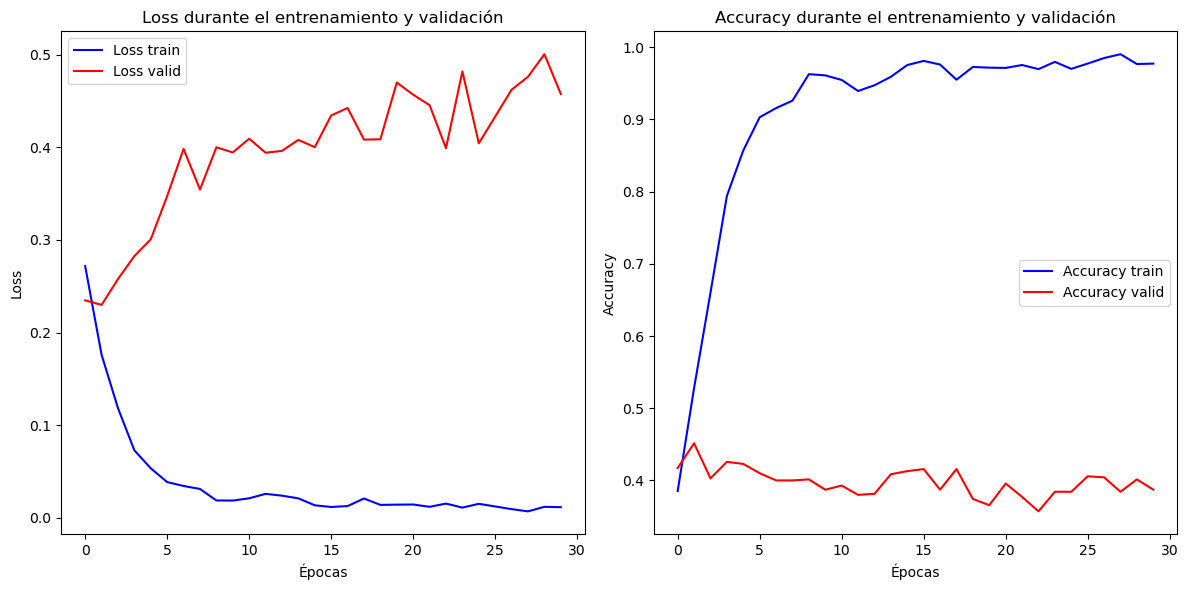

In [37]:
import matplotlib.pyplot as plt

# Graficar la evolución de la Loss durante el entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Subgráfico 1: Loss
plt.plot(range(NUM_EPOCH), loss_hist_train, label='Loss train', color='blue')
plt.plot(range(NUM_EPOCH), loss_hist_val, label='Loss valid', color='red')
plt.title('Loss durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Graficar la evolución de la Accuracy durante el entrenamiento y validación
plt.subplot(1, 2, 2)  # Subgráfico 2: Accuracy
plt.plot(range(NUM_EPOCH), accuracy_hist_train, label='Accuracy train', color='blue')
plt.plot(range(NUM_EPOCH), accuracy_hist_val, label='Accuracy valid', color='red')
plt.title('Accuracy durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar ambas gráficas
plt.tight_layout()
plt.show()